In [42]:
import pandas as pd
import requests
import io
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from transformers import AutoImageProcessor, AutoModel
from tqdm import tqdm
import joblib
from pathlib import Path
import os
from cleanlab import Datalab
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_predict
import cleanlab
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay, matthews_corrcoef
import xgboost as xgb

In [43]:
# Download the dataset from the provided URL
url_train = 'https://public.jacob.al/imd3011-datacentric_ai/hackathon-2025-2/train_no_labels.json.gz'
url_valid = 'https://public.jacob.al/imd3011-datacentric_ai/hackathon-2025-2/valid.json.gz'

response_train = requests.get(url_train)
response_valid = requests.get(url_valid)

# Read the JSON data into pandas DataFrames
train_data = pd.read_json(io.BytesIO(response_train.content), compression='gzip')
valid_data = pd.read_json(io.BytesIO(response_valid.content), compression='gzip')

In [44]:
valid_data

,image,label,is_noisy,uid
0,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...",II,0,d58ccd8d-65b1-4f7d-914b-50ce98c1bbeb
1,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...",V,0,ecccff0d-f2c1-479d-9703-ce18b1635ceb
2,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...",III,0,e04c4f02-0a19-4020-a028-e2ed56d2f081
3,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...",X,0,c0d36cb6-9914-44d4-b7d6-2460cbb599fb
4,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...",I,0,5dfbdf79-2474-44fb-8942-096a3731b4be
...,...,...,...,...
420,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...",VIII,1,2e631889-a3b1-44bb-bed5-de33897f129d
421,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...",III,1,6c97f1f5-de71-4773-ab03-b5e36239cd90
422,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...",VII,0,22c6e775-4729-4eb9-bfea-376031e07611
423,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...",II,0,b636e6dd-a697-471c-b4f1-77a9006fade8


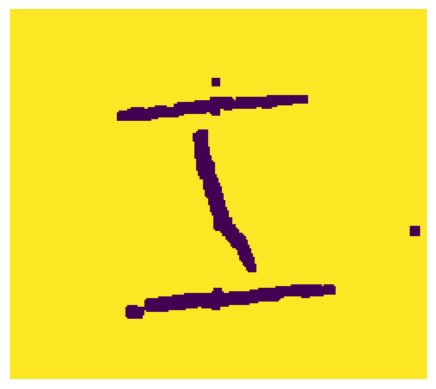

In [45]:
def show_image_from_np_array(np_array):
    np_array = np.array(np_array, dtype=np.uint8)  # Ensure the array is in the correct format
    image = Image.fromarray(np_array)
    plt.imshow(image)
    plt.axis('off')  # Hide the axis
    plt.show()

# Display the first image from the training dataset
show_image_from_np_array(train_data['image'][0])

In [46]:
train_data.shape

(2406, 3)

In [47]:
# --- Configuração Inicial ---
DATASET_NAME = "roman_numerals"
base_image_dir = Path("generated_images") / DATASET_NAME
output_dir = Path("outputs") / DATASET_NAME
output_dir.mkdir(parents=True, exist_ok=True)

# --- Função para Gerar Imagens ---
def generate_images_from_dataframe(dataframe, image_output_dir):
    """
    Salva as imagens de um dataframe em um diretório específico.
    """
    image_output_dir.mkdir(parents=True, exist_ok=True)
    
    files_with_labels = []
    print(f"Iniciando geração de imagens em: {image_output_dir}...")
    
    for index, row in dataframe.iterrows():
        try: 
            image_array = np.array(row['image'], dtype=np.uint8)

            image = Image.fromarray(image_array)
            
            file_path = image_output_dir / f"{row['uid']}.png"
            image.save(file_path)
            files_with_labels.append((str(file_path), row['label']))
            
        except Exception as e:
            print(f"Falha ao salvar a imagem UID={row['uid']} (Índice: {index}). Erro: {e}")
            
    print(f"Geração concluída! {len(files_with_labels)} de {len(dataframe)} imagens foram salvas com sucesso.")
    return files_with_labels

# 1. Definir os diretórios de saída
train_image_dir = base_image_dir / "train"
valid_image_dir = base_image_dir / "valid"

# 2. Gerar imagens para o conjunto de treino
train_files_with_labels = generate_images_from_dataframe(train_data, train_image_dir)

# 3. Gerar imagens para o conjunto de validação
valid_files_with_labels = generate_images_from_dataframe(valid_data, valid_image_dir)

# --- Resumo Final ---
print("\n--- Resumo da Geração de Imagens ---")
print(f"Total de imagens de treino geradas: {len(train_files_with_labels)}")
print(f"Imagens de treino salvas em: {train_image_dir}")
print(f"Total de imagens de validação geradas: {len(valid_files_with_labels)}")
print(f"Imagens de validação salvas em: {valid_image_dir}")

Iniciando geração de imagens em: generated_images/roman_numerals/train...
Geração concluída! 2406 de 2406 imagens foram salvas com sucesso.
Iniciando geração de imagens em: generated_images/roman_numerals/valid...
Geração concluída! 425 de 425 imagens foram salvas com sucesso.

--- Resumo da Geração de Imagens ---
Total de imagens de treino geradas: 2406
Imagens de treino salvas em: generated_images/roman_numerals/train
Total de imagens de validação geradas: 425
Imagens de validação salvas em: generated_images/roman_numerals/valid


In [48]:
# --- 1. Configuração ---
DATASET_NAME = "roman_numerals"
output_dir = Path("outputs") / DATASET_NAME
output_dir.mkdir(exist_ok=True)

# --- 2. Mapeamento de Rótulos (Labels) para IDs Numéricos ---

def roman_to_int(s: str) -> int:
    """Converte uma string de número romano para um inteiro."""
    roman_map = {'I': 1, 'V': 5, 'X': 10, 'L': 50, 'C': 100, 'D': 500, 'M': 1000}
    result = 0
    prev_value = 0
    for char in reversed(s): # Itera da direita para a esquerda
        value = roman_map[char]
        if value < prev_value: # Ex: ao ver 'I' em 'IX', subtrai 1
            result -= value
        else: # Ex: ao ver 'X' em 'IX', soma 10
            result += value
        prev_value = value
    return result

# Pega todos os rótulos de treino e validação
all_labels = [label for _, label in train_files_with_labels] + [label for _, label in valid_files_with_labels]

# Cria uma lista de rótulos únicos
unique_labels_list = list(set(all_labels))

#  Ordena a lista usando a função de conversão como chave
unique_labels = sorted(unique_labels_list, key=roman_to_int)

# Cria os dicionários de mapeamento
label_to_id = {label: i for i, label in enumerate(unique_labels)}
id_to_label = {i: label for i, label in enumerate(unique_labels)}

print("Mapeamento de Rótulos:")
print(label_to_id)


# --- 3. Função Genérica para Extrair Features (Embeddings) ---
def extract_features(
    files_with_labels_list: list[tuple[str, str]],
    mapping_label_to_id: dict[str, int],
    processor: AutoImageProcessor,
    model: AutoModel
) -> list[tuple[int, str, np.ndarray]]:
    """
    Extrai features de uma lista de arquivos de imagem usando um modelo pré-treinado.
    """
    features_data = []
    print(f"Iniciando extração de features para {len(files_with_labels_list)} imagens...")

    for file_path, label_str in tqdm(files_with_labels_list):
        try:
            image = Image.open(file_path).convert("RGB")
            inputs = processor(images=image, return_tensors="pt")
            outputs = model(**inputs)
            last_hidden_states = outputs.last_hidden_state
            feature_vector = last_hidden_states.mean(axis=1).squeeze().detach().numpy()
            
            label_id = mapping_label_to_id[label_str]
            
            features_data.append((label_id, file_path, feature_vector))
        except FileNotFoundError:
            print(f"AVISO: Arquivo não encontrado {file_path}. Pulando.")
        except Exception as e:
            print(f"AVISO: Erro ao processar {file_path}: {e}. Pulando.")

    return features_data

# --- 4. Processo Principal de Extração e Salvamento ---

# Caminhos para os arquivos de features
train_features_file = output_dir / "train_features.joblib"
valid_features_file = output_dir / "valid_features.joblib"

# Verifica se as features já existem para não reprocessar
if not train_features_file.exists() or not valid_features_file.exists():
    print("\nArquivos de features não encontrados. Iniciando extração...")
    
    model_checkpoint = "google/vit-base-patch16-224-in21k"
    print(f"Carregando processador e modelo de '{model_checkpoint}'...")
    processor = AutoImageProcessor.from_pretrained(model_checkpoint)
    model = AutoModel.from_pretrained(model_checkpoint)
    print("Processador e modelo carregados.")

    print("\nExtraindo features de TREINO...")
    train_features = extract_features(
        train_files_with_labels, label_to_id, processor, model
    )
    
    print("\nExtraindo features de VALIDAÇÃO...")
    valid_features = extract_features(
        valid_files_with_labels, label_to_id, processor, model
    )

    print(f"\nSalvando features em '{output_dir}'...")
    joblib.dump(train_features, train_features_file)
    joblib.dump(valid_features, valid_features_file)
    joblib.dump(label_to_id, output_dir / "label_to_id.joblib")
    joblib.dump(id_to_label, output_dir / "id_to_label.joblib")
    print("Features e mapeamentos salvos com sucesso!")

else:
    print(f"Carregando features pré-calculadas de '{output_dir}'...")
    train_features = joblib.load(train_features_file)
    valid_features = joblib.load(valid_features_file)
    # Carrega os mapeamentos também, para garantir consistência
    label_to_id = joblib.load(output_dir / "label_to_id.joblib")
    id_to_label = joblib.load(output_dir / "id_to_label.joblib")
    print("Features e mapeamentos carregados com sucesso!")

# --- 5. Verificação ---
if train_features:
    print(f"\nExemplo de feature de treino (rótulo, arquivo, shape do vetor):")
    label_id_exemplo = train_features[0][0]
    caminho_exemplo = train_features[0][1]
    vetor_exemplo = train_features[0][2]
    
    print(f"  Rótulo Numérico (ID): {label_id_exemplo}")
    print(f"  Arquivo: {Path(caminho_exemplo).name}")
    print(f"  Shape do Vetor de Features: {vetor_exemplo.shape}")

Mapeamento de Rótulos:
{'I': 0, 'II': 1, 'III': 2, 'IV': 3, 'V': 4, 'VI': 5, 'VII': 6, 'VIII': 7, 'IX': 8, 'X': 9}
Carregando features pré-calculadas de 'outputs/roman_numerals'...
Features e mapeamentos carregados com sucesso!

Exemplo de feature de treino (rótulo, arquivo, shape do vetor):
  Rótulo Numérico (ID): 0
  Arquivo: 32e9d51d-8a22-4f97-9955-8f9647a7f13c.png
  Shape do Vetor de Features: (768,)


In [49]:
# A estrutura de cada 'item' em train_features é: (label_id, file_path, feature_vector)

# Extrai os vetores de features (os embeddings) para o conjunto de treino
X_train = np.array([item[2] for item in train_features])
# Extrai os rótulos numéricos (os IDs) para o conjunto de treino
y_train = np.array([item[0] for item in train_features])
# Extrai os caminhos dos arquivos para referência
files_train = np.array([item[1] for item in train_features])


# --- O mesmo processo para os dados de validação ---
# Extrai os vetores de features para o conjunto de validação
X_valid = np.array([item[2] for item in valid_features])
# Extrai os rótulos numéricos para o conjunto de validação
y_valid = np.array([item[0] for item in valid_features])
# Extrai os caminhos dos arquivos para referência
files_valid = np.array([item[1] for item in valid_features])

In [50]:
# --- 1. Criação dos DataFrames ---
# Criando DataFrames para facilitar a manipulação com cleanlab.
df_train = pd.DataFrame({
    "file": files_train,
    "label": y_train,
    "uid": [Path(f).stem for f in files_train]
})


# --- 2. Criação do DataFrame de Validação ---
df_valid = pd.DataFrame({
    "file": files_valid,
    "label": y_valid,
    "uid": [Path(f).stem for f in files_valid]
})

print("DataFrames de treino e validação criados:")
print("df_train head:")
print(df_train.head())
print("-" * 30)


DataFrames de treino e validação criados:
df_train head:
                                                file  label  \
0  generated_images/roman_numerals/train/32e9d51d...      0   
1  generated_images/roman_numerals/train/a7c9faf9...      7   
2  generated_images/roman_numerals/train/0baccef4...      1   
3  generated_images/roman_numerals/train/81fe9a13...      4   
4  generated_images/roman_numerals/train/92e3b890...      1   

                                    uid  
0  32e9d51d-8a22-4f97-9955-8f9647a7f13c  
1  a7c9faf9-a7e2-4687-a57b-ac0558ccee8b  
2  0baccef4-de79-4f71-b7ec-c77cc2ab9e50  
3  81fe9a13-d0fe-43ad-8185-c59ea6117cce  
4  92e3b890-c9ab-4e9c-a63b-ad42de92e5a2  
------------------------------


In [51]:
lab = Datalab(data=df_train, label_name="label")

# Encontramos problemas nos embeddings (features).
issue_types = {"near_duplicate": {}, "outlier": {}}
lab.find_issues(features=X_train, issue_types=issue_types)

# Relatório com o resumo dos problemas encontrados.
print("\n--- Relatório de Issues Encontradas no Conjunto de Treino ---")
lab.report()

Finding near_duplicate issues ...
Finding outlier issues ...

Audit complete. 15 issues found in the dataset.

--- Relatório de Issues Encontradas no Conjunto de Treino ---
Dataset Information: num_examples: 2406, num_classes: 10

Here is a summary of various issues found in your data:

issue_type  num_issues
   outlier          15

Learn about each issue: https://docs.cleanlab.ai/stable/cleanlab/datalab/guide/issue_type_description.html
See which examples in your dataset exhibit each issue via: `datalab.get_issues(<ISSUE_NAME>)`

Data indices corresponding to top examples of each issue are shown below.


---------------------- outlier issues ----------------------

About this issue:
	Examples that are very different from the rest of the dataset 
    (i.e. potentially out-of-distribution or rare/anomalous instances).
    

Number of examples with this issue: 15
Overall dataset quality in terms of this issue: 0.3717

Examples representing most severe instances of this issue:
      is_ou

In [52]:
near_duplicates = lab.get_issues("near_duplicate").query(
    "is_near_duplicate_issue == True"
)
outliers = lab.get_issues("outlier").query("is_outlier_issue == True")
outliers

,is_outlier_issue,outlier_score
667,True,0.097776
869,True,0.133445
889,True,0.091953
1218,True,0.089633
1325,True,0.119005
1445,True,0.133246
1482,True,0.132930
1671,True,0.074335
1906,True,0.101586
2017,True,0.118903


In [ ]:
if 'id_to_label' not in globals():
    raise NameError("Dicionário 'id_to_label' não definido. Execute as células anteriores.")
if 'near_duplicates' not in globals():
    raise NameError("DataFrame 'near_duplicates' não definido. Execute as células anteriores.")
if 'df_train' not in globals():
    raise NameError("DataFrame 'df_train' não definido. Execute as células anteriores.")


# --- Amostragem e Visualização ---
print("--- Visualizando Clusters de Imagens Quase Duplicadas ---")

# Pega uma amostra aleatória dos problemas para não poluir a tela se houver muitos.
if not near_duplicates.empty:
    # Amostra até 10 clusters de duplicatas para inspecionar
    sampled_issues = near_duplicates.sample(min(10, len(near_duplicates)))
else:
    print("Não há duplicatas para exibir.")
    sampled_issues = pd.DataFrame() # Cria um DataFrame vazio para o loop não dar erro

# Itera sobre cada cluster de duplicatas para exibir as imagens
for row in sampled_issues.itertuples():
    # --- Imagem de Referência do Cluster ---
    original_idx = row.Index
    original_file_path = df_train.iloc[original_idx].file
    original_label_id = df_train.iloc[original_idx].label
    original_label_str = id_to_label.get(original_label_id, "Rótulo Desconhecido")

    try:
        original_image = Image.open(original_file_path)
    except Exception as e:
        print(f"Erro ao abrir imagem de referência {original_file_path}: {e}")
        continue

    # --- Imagens Duplicatas do Mesmo Cluster ---
    near_duplicate_images = []
    near_duplicate_titles = []

    for dup_idx in row.near_duplicate_sets:
        try:
            dup_file_path = df_train.iloc[dup_idx].file
            dup_label_id = df_train.iloc[dup_idx].label
            # ADAPTADO: Usa 'id_to_label'
            dup_label_str = id_to_label.get(dup_label_id, "Rótulo Desconhecido")
            
            near_duplicate_images.append(Image.open(dup_file_path))
            # ADAPTADO: Atualiza o texto do título
            title = f"Rótulo: {dup_label_str}\nArquivo: {Path(dup_file_path).name}"
            near_duplicate_titles.append(title)
        except Exception as e:
            print(f"Erro ao abrir imagem duplicata {dup_file_path}: {e}")

    if not near_duplicate_images:
        continue # Pula se nenhuma imagem duplicata pôde ser carregada

    # --- Plotagem ---
    # O número total de imagens a plotar é a original + as duplicatas
    num_images = len(near_duplicate_images) + 1
    plt.figure(figsize=(num_images * 4, 5))

    # Plota a imagem de referência
    plt.subplot(1, num_images, 1)
    plt.imshow(original_image)
    plt.title(f"Referência\nRótulo: {original_label_str}\nArquivo: {Path(original_file_path).name}", fontsize=10)
    plt.axis("off")

    # Plota cada uma das imagens duplicatas
    for i, image in enumerate(near_duplicate_images):
        plt.subplot(1, num_images, i + 2)
        plt.imshow(image)
        plt.title(near_duplicate_titles[i], fontsize=10)
        plt.axis("off")

    plt.suptitle(f"Cluster de Duplicatas ID: {row.near_duplicate_cluster_id}", fontsize=14, y=1.05)
    plt.tight_layout()
    plt.show()

--- Visualizando Clusters de Imagens Quase Duplicadas ---
Não há duplicatas para exibir.



--- Visualizando Imagens Marcadas como Outliers ---


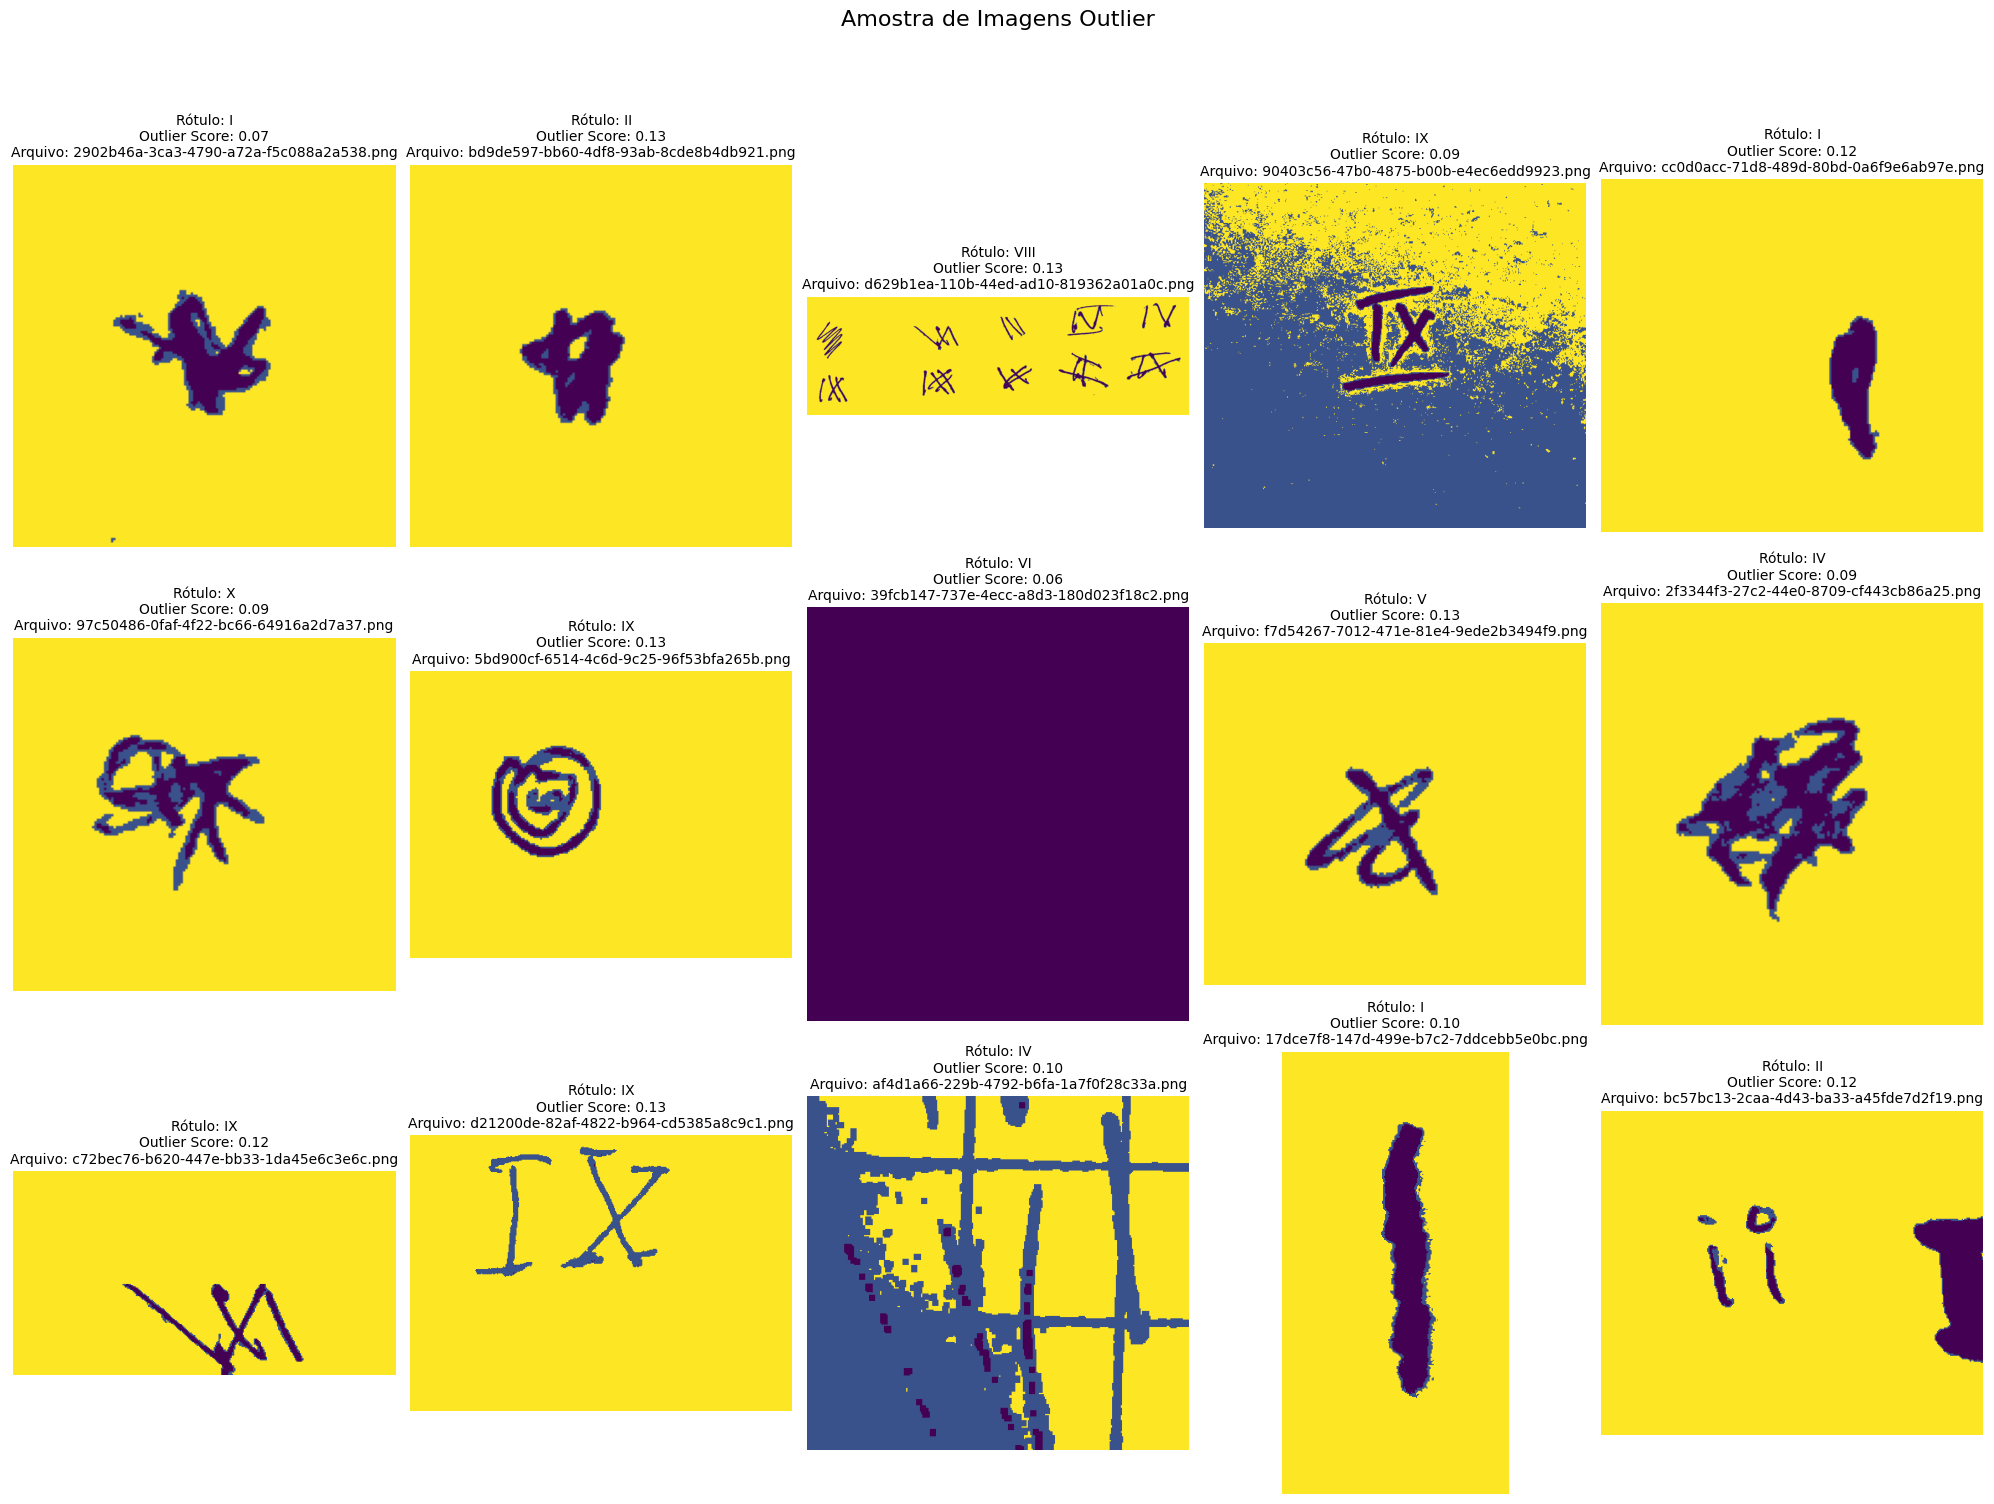

In [54]:
# --- Visualizando as Imagens Outlier ---
print("\n--- Visualizando Imagens Marcadas como Outliers ---")

if not outliers.empty:
    # Pega uma amostra de até 15 outliers para inspecionar
    sampled_outliers = outliers.sample(min(15, len(outliers)))
else:
    print("Não há outliers para exibir.")
    sampled_outliers = pd.DataFrame()

# Calcula o número de colunas para a grade de plotagem
num_cols = 5
num_rows = int(np.ceil(len(sampled_outliers) / num_cols))

if not sampled_outliers.empty:
    plt.figure(figsize=(num_cols * 4, num_rows * 5))
    
    for i, row in enumerate(sampled_outliers.itertuples()):
        idx = row.Index
        file_path = df_train.iloc[idx].file
        label_id = df_train.iloc[idx].label
        label_str = id_to_label.get(label_id, "Rótulo Desconhecido")
        outlier_score = row.outlier_score
        
        plt.subplot(num_rows, num_cols, i + 1)
        try:
            image = Image.open(file_path)
            plt.imshow(image)
            title = (f"Rótulo: {label_str}\n"
                     f"Outlier Score: {outlier_score:.2f}\n"
                     f"Arquivo: {Path(file_path).name}")
            plt.title(title, fontsize=10)
        except Exception as e:
            plt.title(f"Erro ao carregar imagem\n{Path(file_path).name}", fontsize=10)
            print(f"Erro ao abrir imagem outlier {file_path}: {e}")
        
        plt.axis("off")

    plt.suptitle("Amostra de Imagens Outlier", fontsize=16, y=1.0)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

In [55]:


# --- 1. Identificação dos Índices Problemáticos ---
print("Identificando índices de imagens com problemas (outliers ou quase duplicatas)...")

# Usa o Datalab para obter um DataFrame de todos os problemas e filtra
# para pegar os índices das linhas que são ou outlier ou quase duplicata.
problems_idx = (
    lab.get_issues()
    .query("is_outlier_issue == True or is_near_duplicate_issue == True")
    .index
)

if problems_idx.empty:
    print("Nenhum problema encontrado pelo Cleanlab. O dataset já está limpo.")
    # Se não há problemas, os datasets "limpos" são apenas os originais.
    df_train_cleaned = df_train.copy()
    X_train_cleaned = X_train.copy()
    y_train_cleaned = y_train.copy()
else:
    print(f"Encontrados {len(problems_idx)} índices com problemas para remover.")
    
    # --- 2. NOVO: Salvar as Linhas Removidas ---
    # Antes de remover, selecionamos as linhas correspondentes do df_train original.
    df_removed_issues = df_train.loc[problems_idx]
    
    # Define o caminho para o arquivo CSV no nosso diretório de saídas
    removed_issues_filepath = output_dir / "removed_training_issues.csv"
    
    # Salva o DataFrame com as linhas removidas em um arquivo CSV, sem o índice do pandas.
    df_removed_issues.to_csv(removed_issues_filepath, index=False)
    
    print(f"As {len(df_removed_issues)} linhas removidas foram salvas em: {removed_issues_filepath}")

    # --- 3. Remoção dos Dados Problemáticos ---
    print("\nLimpando o conjunto de treinamento...")
    print(f"Tamanho antes da limpeza: {X_train.shape[0]} amostras.")

    # Remove as linhas do DataFrame e reseta o índice
    df_train_cleaned = df_train.drop(problems_idx).reset_index(drop=True)

    # Remove os dados dos arrays numpy (features e labels)
    X_train_cleaned = np.delete(X_train, problems_idx, axis=0)
    y_train_cleaned = np.delete(y_train, problems_idx, axis=0)
    
    print(f"Tamanho após a limpeza: {X_train_cleaned.shape[0]} amostras.")


# --- 4. Verificação Final ---
print("\n--- Resumo da Limpeza ---")
print(f"Formato de X_train original: {X_train.shape}")
print(f"Formato de X_train limpo:    {X_train_cleaned.shape}")
print(f"Total de amostras removidas: {len(X_train) - len(X_train_cleaned)}")

Identificando índices de imagens com problemas (outliers ou quase duplicatas)...
Encontrados 15 índices com problemas para remover.
As 15 linhas removidas foram salvas em: outputs/roman_numerals/removed_training_issues.csv

Limpando o conjunto de treinamento...
Tamanho antes da limpeza: 2406 amostras.
Tamanho após a limpeza: 2391 amostras.

--- Resumo da Limpeza ---
Formato de X_train original: (2406, 768)
Formato de X_train limpo:    (2391, 768)
Total de amostras removidas: 15


In [56]:

print("Preparando para gerar predições 'out-of-sample' com validação cruzada...")

# 1. Define o modelo classificador
# Usamos Regressão Logística, que é um bom e rápido ponto de partida.
model_lr = LogisticRegression(
    random_state=271828,
    n_jobs=-1,  # Usa todos os cores do processador para treinar mais rápido
    class_weight="balanced", # Importante se as classes tiverem tamanhos diferentes
    max_iter=1000 # Aumenta o número de iterações para garantir que o modelo convirja
)

# 2. Define a estratégia de validação cruzada
skfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=271828)

# 3. Gera as predições de probabilidade
out_of_sample_probs = cross_val_predict(
    estimator=model_lr,
    X=X_train_cleaned,
    y=y_train_cleaned, 
    cv=skfold,
    method="predict_proba",
    n_jobs=-1
)

print("\nPredições de probabilidade 'out-of-sample' geradas com sucesso!")
print(f"Formato do array de probabilidades (amostras, classes): {out_of_sample_probs.shape}")
print("Exemplo das probabilidades para a primeira amostra:")
print(out_of_sample_probs[0])

Preparando para gerar predições 'out-of-sample' com validação cruzada...



Predições de probabilidade 'out-of-sample' geradas com sucesso!
Formato do array de probabilidades (amostras, classes): (2391, 10)
Exemplo das probabilidades para a primeira amostra:
[9.82810070e-01 4.35121098e-03 3.54823909e-04 3.04313114e-04
 6.47347474e-03 1.54657293e-03 3.20501222e-03 3.68352954e-05
 8.17237033e-06 9.09514575e-04]


In [57]:
out_of_sample_probs[:5]

array([[9.82810070e-01, 4.35121098e-03, 3.54823909e-04, 3.04313114e-04,
        6.47347474e-03, 1.54657293e-03, 3.20501222e-03, 3.68352954e-05,
        8.17237033e-06, 9.09514575e-04],
       [3.70421872e-03, 1.05364049e-02, 8.78198072e-03, 1.33360591e-01,
        1.71452510e-03, 2.70589981e-02, 3.97194210e-01, 3.26485149e-01,
        9.11274187e-02, 3.65028517e-05],
       [4.17553201e-03, 8.74104589e-01, 1.30536405e-02, 5.09510215e-02,
        1.67944593e-03, 1.33108723e-03, 2.24109436e-02, 2.65502216e-02,
        4.83088310e-03, 9.12635274e-04],
       [3.18281978e-04, 4.96015412e-03, 1.23861098e-03, 1.02706858e-02,
        9.31969061e-01, 5.51990433e-03, 3.87863669e-03, 1.33996986e-03,
        8.30606651e-04, 3.96740888e-02],
       [5.77581613e-02, 2.59929148e-01, 4.31307420e-01, 2.51909553e-02,
        1.00270041e-01, 1.22514325e-03, 4.34379575e-02, 2.27432926e-02,
        2.92077542e-02, 2.89301267e-02]])

In [58]:

print("Calculando os scores de qualidade para cada rótulo no conjunto de treino limpo...")

# Calcula um 'score de qualidade' para cada rótulo.
# Rótulos com scores baixos são os candidatos mais prováveis a estarem incorretos.
label_quality_scores = cleanlab.rank.get_label_quality_scores(
    labels=y_train_cleaned,
    pred_probs=out_of_sample_probs
)

print("Cálculo concluído!")

# Exibe os scores de qualidade para as primeiras 5 amostras do dataset limpo
print("\nScores de Qualidade dos Rótulos (primeiras 5 amostras):")
print(label_quality_scores[:5])

print(f"\nO array de scores tem o formato: {label_quality_scores.shape}")
print("Cada valor no array corresponde a uma amostra em y_train_cleaned.")

Calculando os scores de qualidade para cada rótulo no conjunto de treino limpo...
Cálculo concluído!

Scores de Qualidade dos Rótulos (primeiras 5 amostras):
[0.98281007 0.32648515 0.87410459 0.93196906 0.25992915]

O array de scores tem o formato: (2391,)
Cada valor no array corresponde a uma amostra em y_train_cleaned.


In [59]:

# Pega os índices dos 5 elementos com os menores scores de qualidade de rótulo.
# Estes são os candidatos mais fortes a terem um rótulo incorreto.
top_train_label_quality_scores_idxs = np.argsort(label_quality_scores)[:5]

# Exibe os índices encontrados.
# Estes são os índices relativos ao conjunto de dados limpo (ex: y_train_cleaned).
print("Índices das 5 amostras com os piores rótulos (menor score de qualidade):")
print(top_train_label_quality_scores_idxs)

Índices das 5 amostras com os piores rótulos (menor score de qualidade):
[2081  127  313 1135 1345]


--- Visualizando as 5 Amostras com Pior Qualidade de Rótulo ---


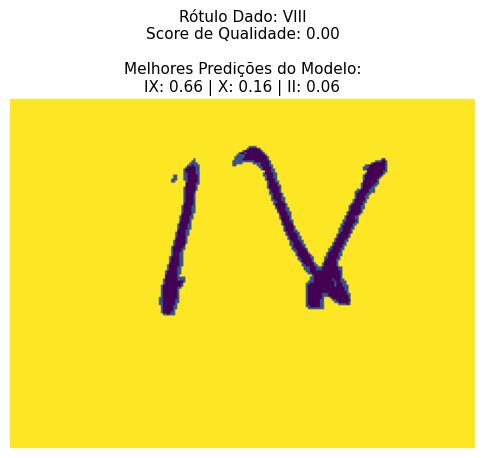

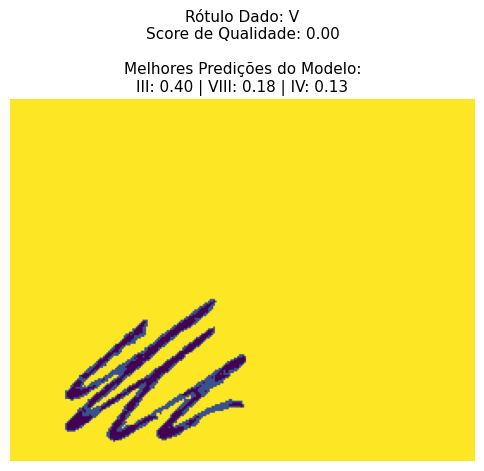

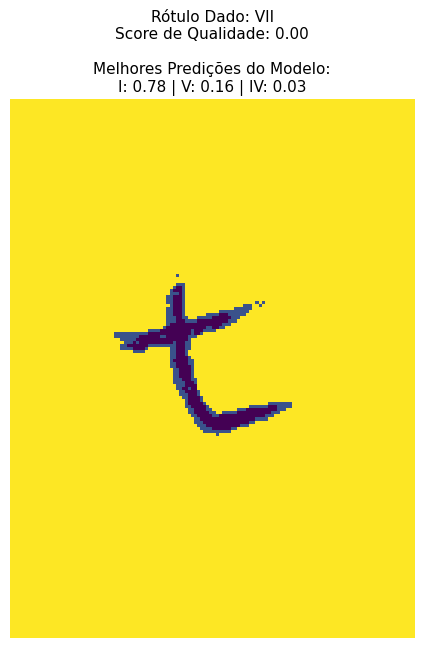

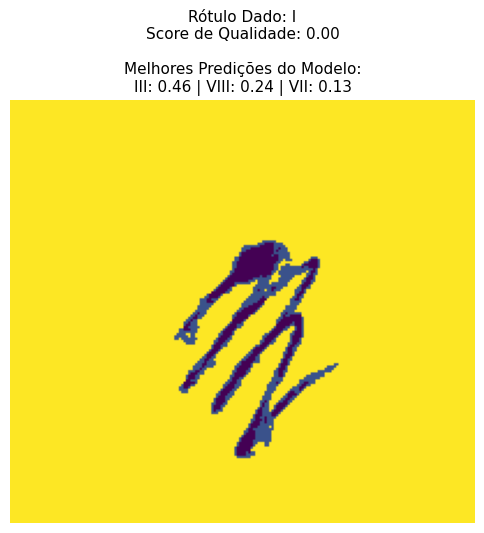

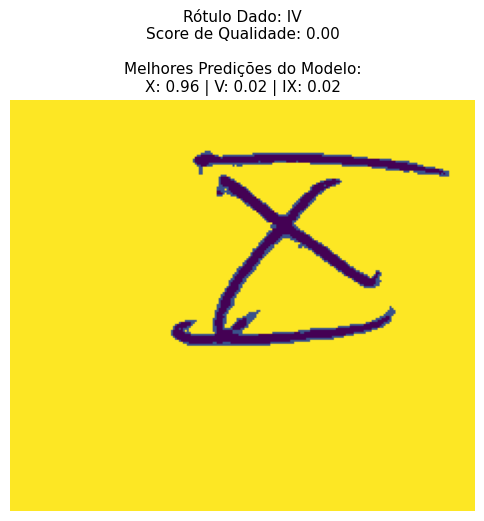

In [60]:
# --- Verificações de Segurança ---
# Garante que todas as variáveis necessárias estão disponíveis na sessão.
required_vars = ['top_train_label_quality_scores_idxs', 'df_train_cleaned', 
                 'y_train_cleaned', 'out_of_sample_probs', 'id_to_label',
                 'label_quality_scores']
for var in required_vars:
    if var not in globals():
        raise NameError(f"Variável necessária '{var}' não foi encontrada. Execute as células anteriores.")


print("--- Visualizando as 5 Amostras com Pior Qualidade de Rótulo ---")

# Itera sobre os índices que identificamos no passo anterior
for i in top_train_label_quality_scores_idxs:
    # --- Coleta de Informações da Amostra ---
    try:
        # Pega o caminho do arquivo a partir do nosso dataframe limpo
        img_path = df_train_cleaned.iloc[i].file
        img = Image.open(img_path)
    except Exception as e:
        print(f"Erro ao abrir a imagem {img_path}: {e}. Pulando.")
        continue

    # Pega o rótulo numérico original (o que estamos avaliando)
    given_numeric_label = y_train_cleaned[i]
    # Converte o rótulo numérico para o texto correspondente (ex: 'IV')
    given_label_str = id_to_label.get(given_numeric_label, f"ID_{given_numeric_label}")
    
    # Pega o score de qualidade para esta amostra específica
    quality_score = label_quality_scores[i]

    # --- Processa as Predições do Modelo para o Título ---
    # Pega as 3 classes com maior probabilidade de predição
    top_3_indices = np.argsort(out_of_sample_probs[i])[-3:][::-1]
    
    top_3_preds_str_list = []
    for class_idx in top_3_indices:
        # Converte o ID da classe predita para o texto (ex: 'V')
        predicted_label_str = id_to_label.get(class_idx, f"ID_{class_idx}")
        # Pega a probabilidade associada
        probability = out_of_sample_probs[i][class_idx]
        top_3_preds_str_list.append(f"{predicted_label_str}: {probability:.2f}")
    
    # Junta as predições em uma única string para o título
    top_preds_display = " | ".join(top_3_preds_str_list)

    # --- Plotagem ---
    plt.figure(figsize=(6, 7))
    plt.imshow(img)
    
    # Cria um título informativo e completo
    title = (
        f"Rótulo Dado: {given_label_str}\n"
        f"Score de Qualidade: {quality_score:.2f}\n\n"
        f"Melhores Predições do Modelo:\n{top_preds_display}"
    )
    
    plt.title(title, fontsize=11)
    plt.axis("off")
    plt.show()

In [61]:
print("--- Método 1: Prune by Noise Rate (PBNR) ---")

ranked_label_issues_pbnr = cleanlab.filter.find_label_issues(
    labels=y_train_cleaned,
    pred_probs=out_of_sample_probs,
    return_indices_ranked_by="self_confidence",
    filter_by="prune_by_noise_rate",
)
print(f"Cleanlab (PBNR) encontrou {len(ranked_label_issues_pbnr)} problemas de rótulo.")
if ranked_label_issues_pbnr.size > 0:
    print(
        f"Top {min(15, len(ranked_label_issues_pbnr))} erros mais prováveis (índices): \n{ranked_label_issues_pbnr[:min(15, len(ranked_label_issues_pbnr))]}"
    )

--- Método 1: Prune by Noise Rate (PBNR) ---
Cleanlab (PBNR) encontrou 233 problemas de rótulo.
Top 15 erros mais prováveis (índices): 
[2081 1135 1345  345 1974 2175 1909  496  611 2389  872 1174 1581 1815
 1306]


In [62]:
print("\n--- Método 2: Prune by Class (PBC) ---")

ranked_label_issues_pbc = cleanlab.filter.find_label_issues(
    labels=y_train_cleaned,
    pred_probs=out_of_sample_probs,
    return_indices_ranked_by="self_confidence",
    filter_by="prune_by_class",
)

print(f"Cleanlab (PBC) encontrou {len(ranked_label_issues_pbc)} problemas de rótulo.")
if ranked_label_issues_pbc.size > 0:
    print(
        f"Top {min(15, len(ranked_label_issues_pbc))} erros mais prováveis (índices): \n{ranked_label_issues_pbc[:min(15, len(ranked_label_issues_pbc))]}"
    )


--- Método 2: Prune by Class (PBC) ---
Cleanlab (PBC) encontrou 241 problemas de rótulo.
Top 15 erros mais prováveis (índices): 
[2081  127  313 1135 1345  345 1974 2175 1909 1350  411 2142 1887 2284
  496]


In [63]:
print("\n--- Método 3: Both (PBNR e PBC) ---")

ranked_label_issues_pbnr_pbc = cleanlab.filter.find_label_issues(
    labels=y_train_cleaned,
    pred_probs=out_of_sample_probs,
    return_indices_ranked_by="self_confidence",
    filter_by="both",
)

print(f"Cleanlab (Both) encontrou {len(ranked_label_issues_pbnr_pbc)} problemas de rótulo.")
if ranked_label_issues_pbnr_pbc.size > 0:
    print(
        f"Top {min(15, len(ranked_label_issues_pbnr_pbc))} erros mais prováveis (índices): \n{ranked_label_issues_pbnr_pbc[:min(15, len(ranked_label_issues_pbnr_pbc))]}"
    )


--- Método 3: Both (PBNR e PBC) ---
Cleanlab (Both) encontrou 156 problemas de rótulo.
Top 15 erros mais prováveis (índices): 
[2081 1135 1345  345 1974 2175 1909  496  611 2389  872 1174 1581 1815
 1306]


In [64]:
print("\n--- Método 4: Confident Learning (Original) ---")

ranked_label_issues_cl = cleanlab.filter.find_label_issues(
    labels=y_train_cleaned,
    pred_probs=out_of_sample_probs,
    return_indices_ranked_by="self_confidence",
    filter_by="confident_learning",
)

print(f"Cleanlab (Confident Learning) encontrou {len(ranked_label_issues_cl)} problemas de rótulo.")
if ranked_label_issues_cl.size > 0:
    print(
        f"Top {min(15, len(ranked_label_issues_cl))} erros mais prováveis (índices): \n{ranked_label_issues_cl[:min(15, len(ranked_label_issues_cl))]}"
    )


--- Método 4: Confident Learning (Original) ---
Cleanlab (Confident Learning) encontrou 155 problemas de rótulo.
Top 15 erros mais prováveis (índices): 
[1345  345 1974 2175 1909  872 1581 1306  944  518 1497  451 2045 1883
 2279]


In [65]:
# Compara os resultados do método padrão 'confident_learning' (cl) com o método mais restritivo 'both'.

# 1. Encontra os índices que estão na lista 'cl', mas NÃO estão na lista 'both'.
# Estes são os erros que o método padrão encontrou, mas que o método restritivo ignorou.
in_ranked_label_issues_cl_not_in_ranked_label_issues_pbnr_pbc = list(
    set(ranked_label_issues_cl).difference(set(ranked_label_issues_pbnr_pbc))
)

# 2. Encontra os índices que estão na lista 'both', mas NÃO estão na lista 'cl'.
# Estes seriam casos mais raros, onde a combinação das heurísticas PBNR e PBC encontrou
# algo que o algoritmo principal 'confident_learning' não encontrou.
in_ranked_label_issues_pbnr_pbc_not_in_ranked_label_issues_cl = list(
    set(ranked_label_issues_pbnr_pbc).difference(set(ranked_label_issues_cl))
)


# 3. Imprime os resultados da comparação.
print("--- Comparação entre os Métodos de Filtragem 'confident_learning' vs. 'both' ---")

print(
    f"Existem {len(in_ranked_label_issues_cl_not_in_ranked_label_issues_pbnr_pbc)} problemas de rótulo encontrados por 'confident_learning' que NÃO foram encontrados pelo método 'both'."
)

print(
    f"Existem {len(in_ranked_label_issues_pbnr_pbc_not_in_ranked_label_issues_cl)} problemas de rótulo encontrados por 'both' que NÃO foram encontrados pelo método 'confident_learning'."
)

--- Comparação entre os Métodos de Filtragem 'confident_learning' vs. 'both' ---
Existem 65 problemas de rótulo encontrados por 'confident_learning' que NÃO foram encontrados pelo método 'both'.
Existem 66 problemas de rótulo encontrados por 'both' que NÃO foram encontrados pelo método 'confident_learning'.


In [66]:
flagged_by_at_least_one_method = np.unique(
    np.concatenate(
        [
            ranked_label_issues_pbnr,
            ranked_label_issues_pbc,
            ranked_label_issues_cl,
            ranked_label_issues_pbnr_pbc,
        ]
    )
)
flagged_by_at_least_one_method

array([   8,   17,   24,   27,   33,   36,   40,   49,   50,   56,   59,
         60,   74,   91,   94,  102,  122,  127,  131,  137,  141,  144,
        148,  153,  158,  164,  165,  175,  176,  181,  194,  199,  206,
        210,  218,  227,  247,  251,  272,  277,  280,  284,  286,  298,
        299,  301,  305,  307,  313,  322,  323,  333,  345,  354,  359,
        378,  390,  399,  404,  407,  411,  412,  413,  414,  421,  428,
        429,  430,  450,  451,  452,  453,  463,  466,  468,  471,  477,
        482,  488,  492,  494,  496,  503,  506,  512,  518,  528,  530,
        537,  543,  565,  569,  581,  597,  602,  611,  613,  635,  642,
        650,  665,  666,  669,  677,  681,  688,  690,  703,  708,  711,
        714,  751,  759,  760,  763,  767,  779,  801,  806,  814,  821,
        834,  836,  848,  852,  872,  875,  880,  881,  895,  896,  902,
        906,  920,  928,  944,  950,  964,  970,  971,  978,  988,  997,
       1005, 1021, 1028, 1030, 1038, 1047, 1063, 10

--- Visualizando as 15 primeiras imagens da lista consolidada de problemas ---


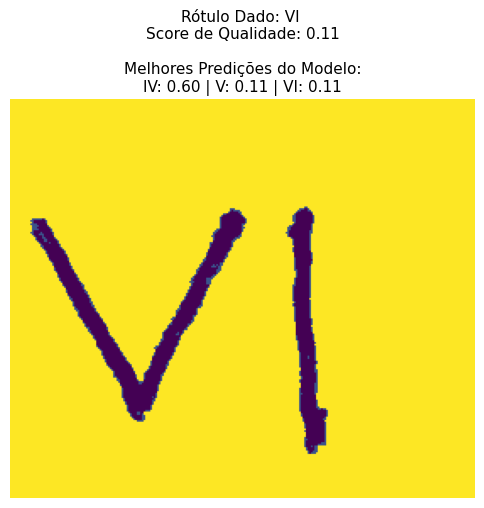

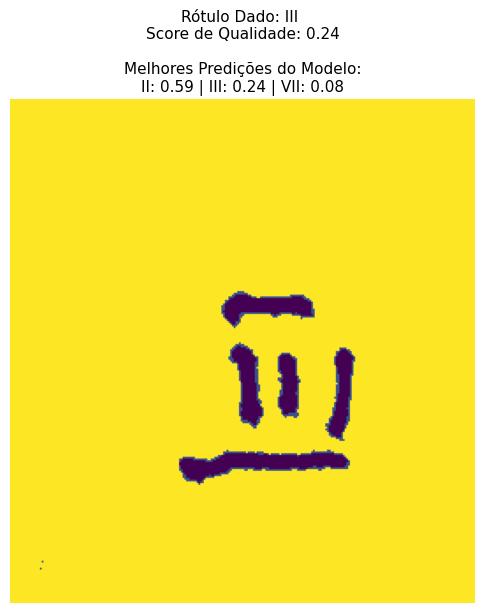

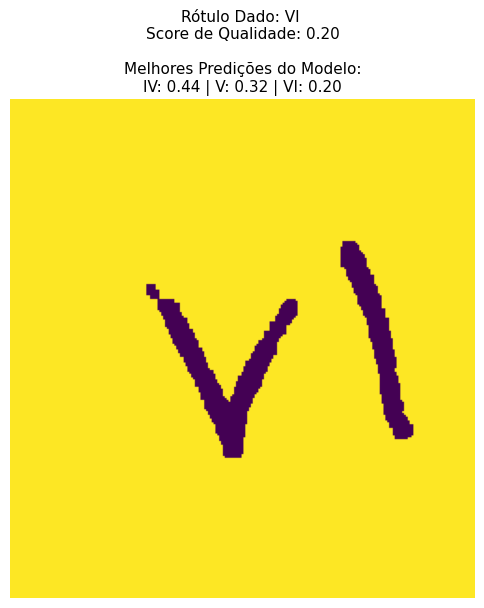

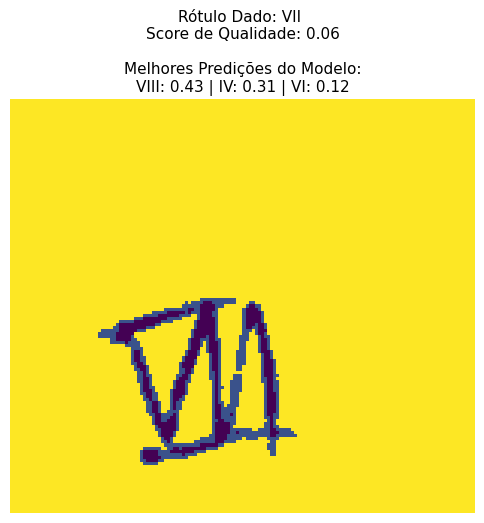

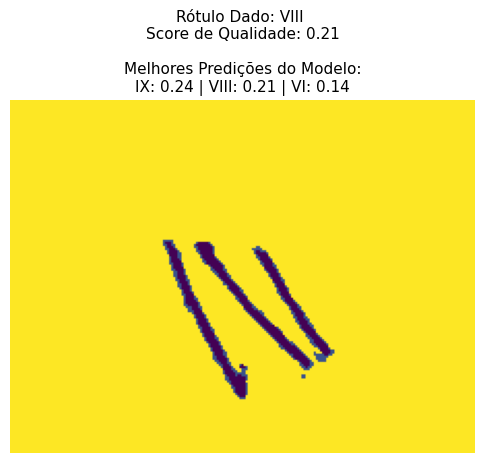

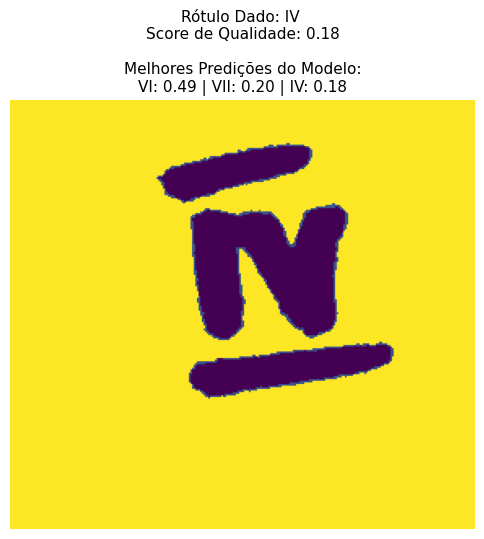

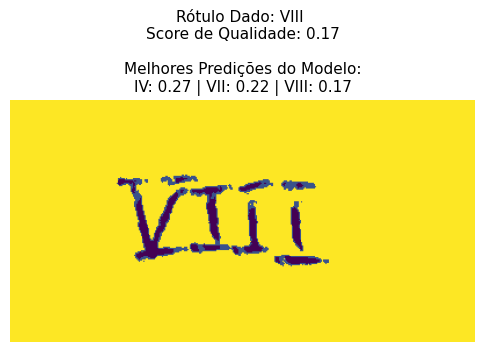

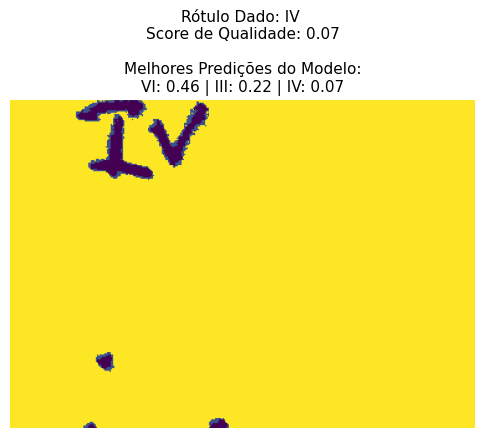

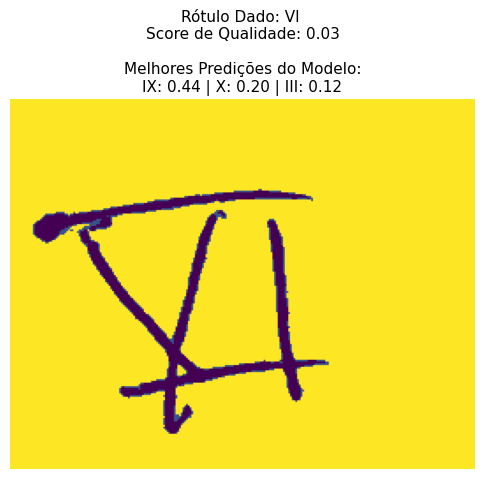

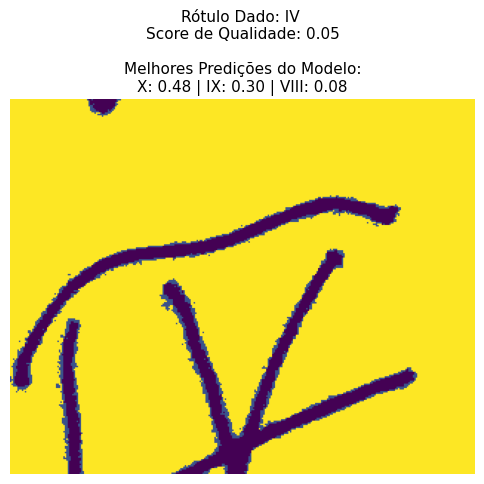

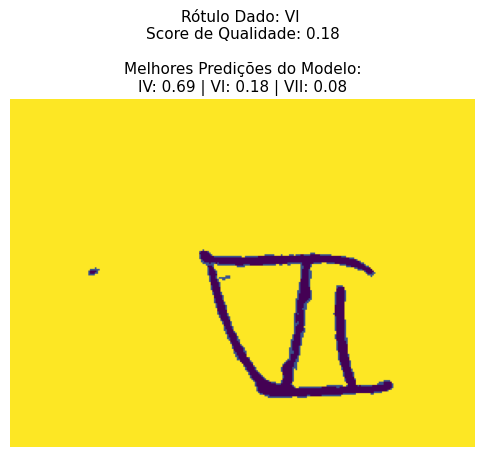

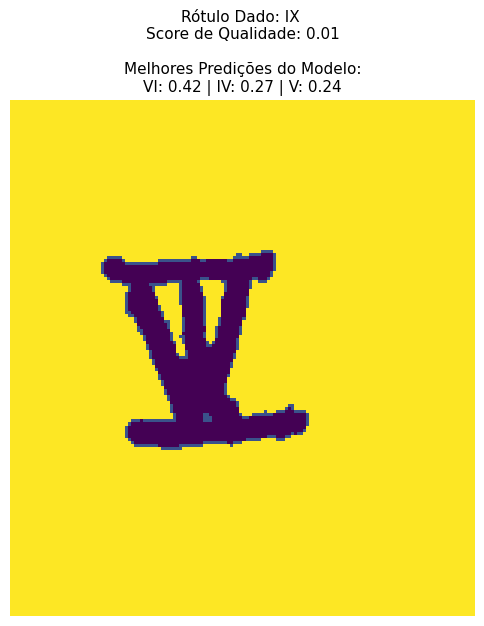

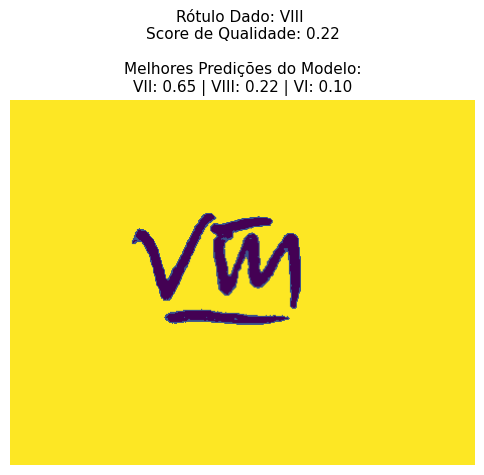

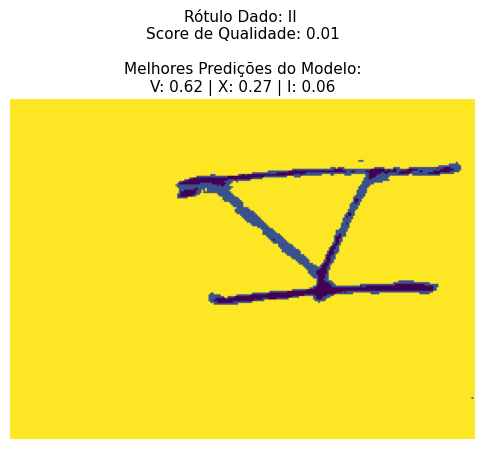

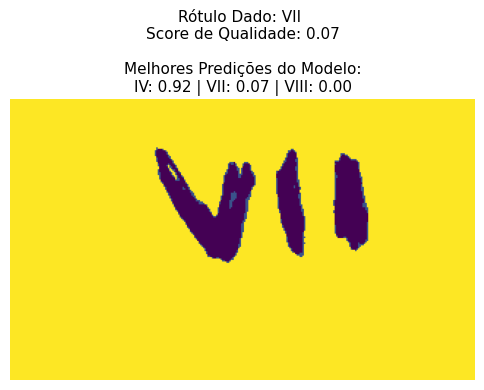

In [67]:


# --- 1. Verificações de Segurança ---
# Garante que todas as variáveis necessárias estão disponíveis.
required_vars = [
    'flagged_by_at_least_one_method', 'df_train_cleaned', 'y_train_cleaned',
    'out_of_sample_probs', 'id_to_label', 'label_quality_scores'
]
for var in required_vars:
    if var not in globals():
        raise NameError(f"Variável necessária '{var}' não foi encontrada. Execute as células anteriores.")


# --- 2. Configuração da Plotagem ---
NUM_IMAGES_TO_PLOT = 15
# Pega os primeiros N índices da nossa lista consolidada de problemas.
indices_to_plot = flagged_by_at_least_one_method[:NUM_IMAGES_TO_PLOT]

print(f"--- Visualizando as {len(indices_to_plot)} primeiras imagens da lista consolidada de problemas ---")
if not indices_to_plot.any():
    print("Nenhuma imagem marcada para visualização.")


# --- 3. Loop de Visualização ---
for i in indices_to_plot:
    try:
        # --- Coleta de Informações da Amostra ---
        # Usa o índice 'i' para buscar informações em todas as nossas estruturas de dados.
        img_path = df_train_cleaned.iloc[i].file
        given_numeric_label = y_train_cleaned[i]
        given_label_str = id_to_label.get(given_numeric_label, f"ID_{given_numeric_label}")
        quality_score = label_quality_scores[i] # Score de qualidade do rótulo
        
        # --- Processa as Predições do Modelo ---
        probs = out_of_sample_probs[i]
        top_3_indices = np.argsort(probs)[-3:][::-1]
        
        top_preds_list = []
        for class_idx in top_3_indices:
            pred_label_str = id_to_label.get(class_idx, f"ID_{class_idx}")
            probability = probs[class_idx]
            top_preds_list.append(f"{pred_label_str}: {probability:.2f}")
        
        top_preds_display = " | ".join(top_preds_list)
        
        # --- Plotagem da Imagem e Título ---
        img = Image.open(img_path)
        plt.figure(figsize=(6, 7))
        plt.imshow(img)
        
        # Cria um título completo para diagnóstico
        title = (
            f"Rótulo Dado: {given_label_str} \n"
            f"Score de Qualidade: {quality_score:.2f}\n\n"
            f"Melhores Predições do Modelo:\n{top_preds_display}"
        )
        
        plt.title(title, fontsize=11)
        plt.axis("off")
        plt.show()

    except Exception as e:
        print(f"ERRO: Não foi possível processar a imagem no índice {i}. Motivo: {e}")

In [68]:
# --- 1. Definir os Índices a Remover ---
indices_to_remove = flagged_by_at_least_one_method

# --- 2. Salvar as Linhas com Erros de Rótulo (Antes de Remover) ---
if indices_to_remove.size > 0:
    print(f"Salvando as {len(indices_to_remove)} linhas com erros de rótulo identificados...")
    
    # Seleciona as linhas a serem removidas do dataframe semi-limpo
    df_removed_label_issues = df_train_cleaned.loc[indices_to_remove]
    
    # Define o caminho do arquivo de saída
    removed_issues_filepath = output_dir / "removed_label_issues.csv"
    
    # Salva o dataframe em um arquivo CSV para registro
    df_removed_label_issues.to_csv(removed_issues_filepath, index=False)
    
    print(f"Linhas salvas com sucesso em: {removed_issues_filepath}")
else:
    print("Nenhum erro de rótulo encontrado para remover.")

# --- 3. Executar a Remoção Final ---
print(f"\nIniciando remoção final. Tamanho antes: {len(df_train_cleaned)} amostras.")

if indices_to_remove.size > 0:
    # Remove as linhas do DataFrame e reseta o índice.
    # As novas variáveis terminam com '_2' para indicar a segunda rodada de limpeza.
    df_train_cleaned_2 = df_train_cleaned.drop(indices_to_remove).reset_index(drop=True)

    # Remove as linhas correspondentes dos arrays NumPy de features e rótulos
    X_train_cleaned_2 = np.delete(X_train_cleaned, indices_to_remove, axis=0)
    y_train_cleaned_2 = np.delete(y_train_cleaned, indices_to_remove, axis=0)
    
    print(f"Remoção concluída. Tamanho após: {len(df_train_cleaned_2)} amostras.")
else:
    # Se não há nada a remover, os dataframes finais são cópias dos anteriores.
    df_train_cleaned_2 = df_train_cleaned.copy()
    X_train_cleaned_2 = X_train_cleaned.copy()
    y_train_cleaned_2 = y_train_cleaned.copy()


# --- 4. Verificação Final ---
print("\n--- Resumo Final do Processo de Limpeza ---")
print(f"Tamanho original do dataset de treino: {len(df_train)} amostras")
print(f"Tamanho após limpeza 1 (outliers/duplicatas): {len(df_train_cleaned)} amostras")
print(f"Tamanho após limpeza 2 (erros de rótulo): {len(df_train_cleaned_2)} amostras")
print("-" * 30)
print(f"Formato do X_train final: {X_train_cleaned_2.shape}")
print(f"Formato do y_train final: {y_train_cleaned_2.shape}")

Salvando as 328 linhas com erros de rótulo identificados...
Linhas salvas com sucesso em: outputs/roman_numerals/removed_label_issues.csv

Iniciando remoção final. Tamanho antes: 2391 amostras.
Remoção concluída. Tamanho após: 2063 amostras.

--- Resumo Final do Processo de Limpeza ---
Tamanho original do dataset de treino: 2406 amostras
Tamanho após limpeza 1 (outliers/duplicatas): 2391 amostras
Tamanho após limpeza 2 (erros de rótulo): 2063 amostras
------------------------------
Formato do X_train final: (2063, 768)
Formato do y_train final: (2063,)


In [69]:
print("Consolidando todos os registros removidos em um único DataFrame...")

# --- 1. Verificação e Carregamento dos DataFrames ---
first_removed_filepath = output_dir / "removed_training_issues.csv"
second_removed_filepath = output_dir / "removed_label_issues.csv"

# Carrega o primeiro DataFrame se ele não existir na memória
if 'df_removed_issues' not in globals():
    if first_removed_filepath.exists():
        print(f"Carregando o primeiro conjunto de remoções de: {first_removed_filepath}")
        df_removed_issues = pd.read_csv(first_removed_filepath)
    else:
        # Se não houver o arquivo, cria um DataFrame vazio para não dar erro
        print("AVISO: Arquivo do primeiro conjunto de remoções não encontrado. Assumindo que não houve remoções.")
        df_removed_issues = pd.DataFrame()

# Carrega o segundo DataFrame se ele não existir na memória
if 'df_removed_label_issues' not in globals():
    if second_removed_filepath.exists():
        print(f"Carregando o segundo conjunto de remoções de: {second_removed_filepath}")
        df_removed_label_issues = pd.read_csv(second_removed_filepath)
    else:
        print("AVISO: Arquivo do segundo conjunto de remoções não encontrado. Assumindo que não houve remoções.")
        df_removed_label_issues = pd.DataFrame()


# --- 2. Concatenação e Limpeza ---
df_all_removed_rows = pd.concat([df_removed_issues, df_removed_label_issues], ignore_index=True)

# Remove linhas duplicadas baseando-se no 'uid' para garantir que cada amostra apareça apenas uma vez
rows_before_dedup = len(df_all_removed_rows)
df_all_removed_consolidated = df_all_removed_rows.drop_duplicates(subset=['uid'], keep='first')
rows_after_dedup = len(df_all_removed_consolidated)

if rows_before_dedup > rows_after_dedup:
    print(f"{rows_before_dedup - rows_after_dedup} duplicatas foram removidas da lista consolidada.")


# --- 3. Salvar e Exibir o Resultado Final ---
consolidated_filepath = output_dir / "ALL_REMOVED_ROWS_CONSOLIDATED.csv"
df_all_removed_consolidated.to_csv(consolidated_filepath, index=False)

print(f"\nArquivo consolidado com todas as {len(df_all_removed_consolidated)} linhas removidas foi salvo em: {consolidated_filepath}")

print("\nAmostra do DataFrame consolidado de todas as linhas removidas:")
display(df_all_removed_consolidated.head())

Consolidando todos os registros removidos em um único DataFrame...

Arquivo consolidado com todas as 343 linhas removidas foi salvo em: outputs/roman_numerals/ALL_REMOVED_ROWS_CONSOLIDATED.csv

Amostra do DataFrame consolidado de todas as linhas removidas:


,file,label,uid
0,generated_images/roman_numerals/train/af4d1a66...,3,af4d1a66-229b-4792-b6fa-1a7f0f28c33a
1,generated_images/roman_numerals/train/5bd900cf...,4,5bd900cf-6514-4c6d-9c25-96f53bfa265b
2,generated_images/roman_numerals/train/90403c56...,4,90403c56-47b0-4875-b00b-e4ec6edd9923
3,generated_images/roman_numerals/train/97c50486...,9,97c50486-0faf-4f22-bc66-64916a2d7a37
4,generated_images/roman_numerals/train/cc0d0acc...,0,cc0d0acc-71d8-489d-80bd-0a6f9e6ab97e


In [70]:
df_all_removed_consolidated.shape

(343, 3)

In [71]:
# --- 1. Treinamento do Modelo Final ---

print("Treinando o modelo final com os dados de treino ultra-limpos (X_train_cleaned_2)...")

# Inicializa o mesmo modelo de Regressão Logística que usamos antes
model_lr_final = LogisticRegression(
    random_state=271828, n_jobs=-1, class_weight="balanced", max_iter=1000
)

# TREINA o modelo com TODO o nosso dataset de treino ultra-limpo
model_lr_final.fit(X_train_cleaned_2, y_train_cleaned_2)

print("Treinamento concluído.")


# --- 2. Geração de Predições para o Conjunto de Validação ---
print("\nGerando predições para o conjunto de validação...")

validation_pred_probs = model_lr_final.predict_proba(X_valid)

print(f"Predições geradas para as {len(X_valid)} amostras de validação.")


# --- 3. Análise do Conjunto de Validação com Cleanlab ---
print("\nAnalisando o conjunto de validação com Cleanlab...")

# Inicializa um NOVO objeto Datalab, agora com os dados de validação
lab_valid = Datalab(data=df_valid, label_name="label")

# Encontra problemas nos dados de validação usando as predições do nosso modelo final
lab_valid.find_issues(features=X_valid, pred_probs=validation_pred_probs)


# --- 4. Relatório Final ---
print("\n--- Relatório de Issues Encontradas no Conjunto de Validação ---")
lab_valid.report()

Treinando o modelo final com os dados de treino ultra-limpos (X_train_cleaned_2)...
Treinamento concluído.

Gerando predições para o conjunto de validação...
Predições geradas para as 425 amostras de validação.

Analisando o conjunto de validação com Cleanlab...
Finding null issues ...
Finding label issues ...
Finding outlier issues ...
Finding near_duplicate issues ...
Finding non_iid issues ...
Finding class_imbalance issues ...
Finding underperforming_group issues ...

Audit complete. 45 issues found in the dataset.

--- Relatório de Issues Encontradas no Conjunto de Validação ---
Dataset Information: num_examples: 425, num_classes: 10

Here is a summary of various issues found in your data:

issue_type  num_issues
     label          40
   outlier           5

Learn about each issue: https://docs.cleanlab.ai/stable/cleanlab/datalab/guide/issue_type_description.html
See which examples in your dataset exhibit each issue via: `datalab.get_issues(<ISSUE_NAME>)`

Data indices correspond

In [72]:
# Gera o relatório para o objeto Datalab do conjunto de VALIDAÇÃO.
lab_valid.report()

Dataset Information: num_examples: 425, num_classes: 10

Here is a summary of various issues found in your data:

issue_type  num_issues
     label          40
   outlier           5

Learn about each issue: https://docs.cleanlab.ai/stable/cleanlab/datalab/guide/issue_type_description.html
See which examples in your dataset exhibit each issue via: `datalab.get_issues(<ISSUE_NAME>)`

Data indices corresponding to top examples of each issue are shown below.


----------------------- label issues -----------------------

About this issue:
	Examples whose given label is estimated to be potentially incorrect
    (e.g. due to annotation error) are flagged as having label issues.
    

Number of examples with this issue: 40
Overall dataset quality in terms of this issue: 0.9365

Examples representing most severe instances of this issue:
     is_label_issue  label_score  given_label  predicted_label
417            True     0.000010            8                9
97             True     0.000056

--- Visualizando Outliers Encontrados no Conjunto de Validação ---
Visualizando os 5 outliers mais significativos (de 5 encontrados)...


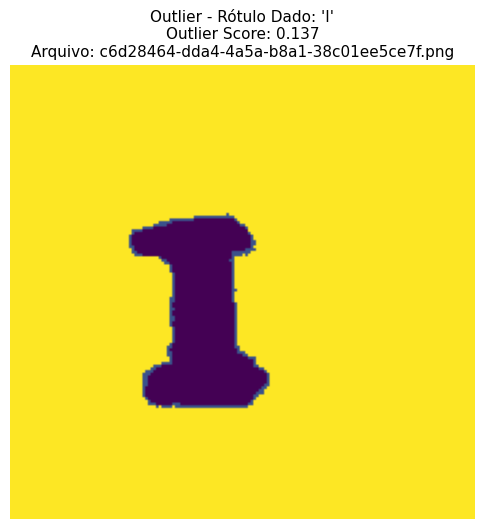

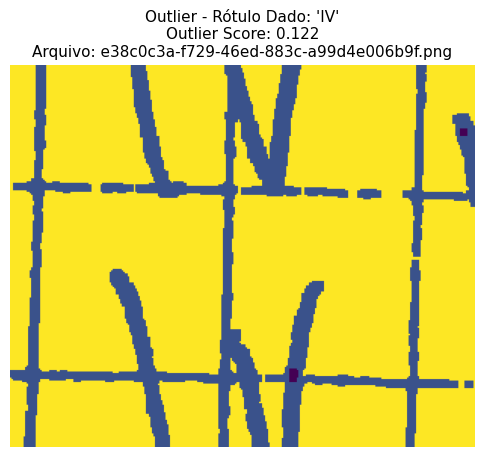

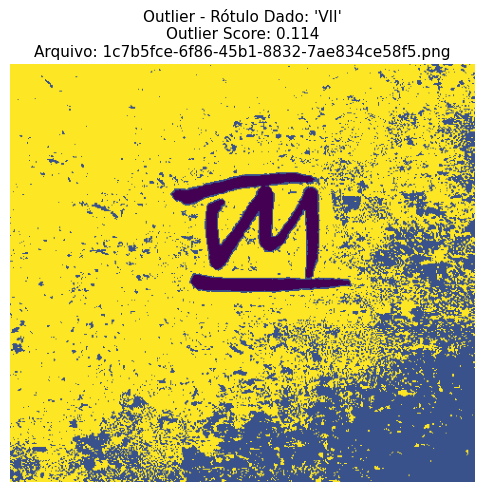

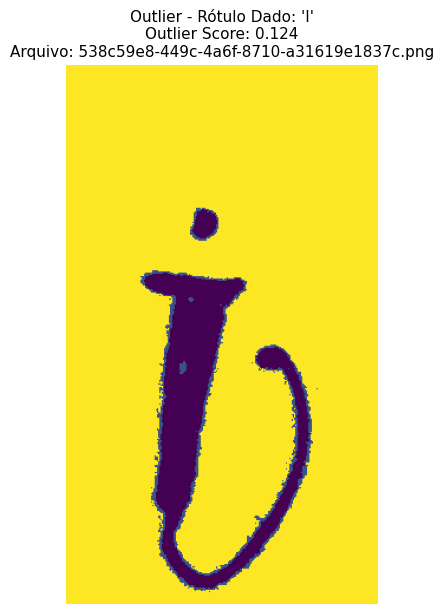

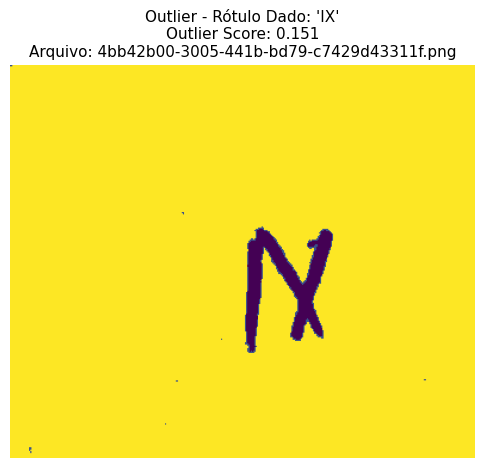

In [73]:
# --- 1. Verificações de Segurança ---
required_vars = ['lab_valid', 'df_valid', 'id_to_label']
for var in required_vars:
    if var not in globals():
        raise NameError(f"Variável necessária '{var}' não foi encontrada. Execute as células anteriores.")

# --- 2. Obter e Filtrar os Outliers ---
print("--- Visualizando Outliers Encontrados no Conjunto de Validação ---")

# Pega o relatório de outliers do nosso objeto lab_valid
outlier_issues = lab_valid.get_issues("outlier")

# Filtra para manter apenas os que são marcados como outliers
outliers_df = outlier_issues.query("is_outlier_issue == True")

if outliers_df.empty:
    print("Nenhum outlier foi encontrado no conjunto de validação.")
else:
    # --- 3. Preparar para Plotagem ---
    # O cleanlab já ordena os outliers do mais significativo (menor score) para o menos.
    # Vamos pegar os 15 primeiros para visualizar.
    NUM_TO_PLOT = 15
    outliers_to_plot = outliers_df.head(NUM_TO_PLOT)
    
    print(f"Visualizando os {len(outliers_to_plot)} outliers mais significativos (de {len(outliers_df)} encontrados)...")

    # --- 4. Loop de Visualização ---
    for row in outliers_to_plot.itertuples():
        try:
            # O row.Index aqui é o índice original do df_valid
            original_df_index = row.Index
            
            # Coleta todas as informações necessárias usando o índice
            img_path = df_valid.loc[original_df_index].file
            numeric_label = df_valid.loc[original_df_index].label
            label_str = id_to_label.get(numeric_label, f"ID_{numeric_label}")
            outlier_score = row.outlier_score # A pontuação do outlier
            
            # Abre a imagem
            img = Image.open(img_path)
            
            # --- Plotagem ---
            plt.figure(figsize=(6, 7))
            plt.imshow(img)
            
            # Cria um título completo e informativo
            title = (
                f"Outlier - Rótulo Dado: '{label_str}'\n"
                f"Outlier Score: {outlier_score:.3f}\n" # Adicionamos o score!
                f"Arquivo: {Path(img_path).name}"
            )
            
            plt.title(title, fontsize=11)
            plt.axis("off")
            plt.show()

        except Exception as e:
            print(f"ERRO: Não foi possível processar o outlier no índice {original_df_index}. Motivo: {e}")

In [74]:

print("Iniciando a adição dos outliers da validação ao log de erros...")

# --- 1. Obter os Índices a Serem Adicionados ---
indices_to_log = outliers_to_plot.index

if indices_to_log.empty:
    print("O DataFrame 'outliers_to_plot' está vazio. Nenhum registro a ser adicionado.")
else:
    print(f"Serão adicionadas {len(indices_to_log)} amostras de outliers ao log .")
    
    # --- 2. Isolar as Linhas de Validação a Serem Registradas ---
    # Usamos os índices para pegar as linhas completas do df_valid original.
    df_removed_from_valid = df_valid.loc[indices_to_log]

    # --- 3. Adicionar ao DataFrame Consolidado de Remoções ---
    print("Atualizando o log ...")
    
    # Garante que o log  principal exista
    if 'df_all_removed_consolidated' not in globals():
        # Por segurança, inicia um DataFrame vazio se ele não for encontrado.
        print("AVISO: 'df_all_removed_consolidated' não encontrado, iniciando um novo log.")
        df_all_removed_consolidated = pd.DataFrame()
        
    # Concatena o log existente com os novos outliers a serem registrados
    df_all_removed_final = pd.concat(
        [df_all_removed_consolidated, df_removed_from_valid],
        ignore_index=True
    )
    
    # Garante que o log final não tenha duplicatas, usando 'uid' como chave
    df_all_removed_final = df_all_removed_final.drop_duplicates(subset=['uid'], keep='first')
    
    # Salva o log final e atualizado
    consolidated_filepath = output_dir / "ALL_REMOVED_ROWS_CONSOLIDATED.csv"
    df_all_removed_final.to_csv(consolidated_filepath, index=False)
    print(f"Log consolidado final atualizado e salvo. Contém agora {len(df_all_removed_final)} registros.")

    # --- 4. Verificação ---
    print("\n--- Amostra do Log Consolidado Final ---")
    display(df_all_removed_final.tail()) # Mostra as últimas linhas, que são as que acabamos de adicionar

Iniciando a adição dos outliers da validação ao log de erros...
Serão adicionadas 5 amostras de outliers ao log .
Atualizando o log ...
Log consolidado final atualizado e salvo. Contém agora 348 registros.

--- Amostra do Log Consolidado Final ---


,file,label,uid
343,generated_images/roman_numerals/valid/c6d28464...,0,c6d28464-dda4-4a5a-b8a1-38c01ee5ce7f
344,generated_images/roman_numerals/valid/e38c0c3a...,3,e38c0c3a-f729-46ed-883c-a99d4e006b9f
345,generated_images/roman_numerals/valid/1c7b5fce...,7,1c7b5fce-6f86-45b1-8832-7ae834ce58f5
346,generated_images/roman_numerals/valid/538c59e8...,0,538c59e8-449c-4a6f-8710-a31619e1837c
347,generated_images/roman_numerals/valid/4bb42b00...,4,4bb42b00-3005-441b-bd79-c7429d43311f


In [75]:
# --- 1. Verificação de Segurança ---
if 'train_data' not in globals() or 'df_all_removed_final' not in globals():
    raise NameError("Os DataFrames 'train_data' e/ou 'df_all_removed_final' não foram encontrados. Por favor, execute os passos anteriores.")

print("Iniciando a criação do novo DataFrame com as flags 'is_noisy'...")

# --- 2. Otimização: Criar um conjunto (set) de UIDs problemáticos ---
problematic_uids = set(df_all_removed_final['uid'])
print(f"Encontrados {len(problematic_uids)} UIDs únicos na lista de problemas.")

# --- 3. Criar a coluna 'is_noisy' ---
is_noisy_column = train_data['uid'].isin(problematic_uids).astype(int)

# --- 4. Criar o DataFrame Final ---
df_train_noisy_flags = pd.DataFrame({
    'uid': train_data['uid'],
    'is_noisy': is_noisy_column
})

# --- 5. Verificação e Amostra ---
print("\nNovo DataFrame 'df_train_noisy_flags' criado com sucesso!")
print(f"Total de linhas: {len(df_train_noisy_flags)}")

# Mostra quantas amostras foram marcadas como 0 (limpas) e 1 (problemáticas)
print("\nContagem de valores na coluna 'is_noisy':")
print(df_train_noisy_flags['is_noisy'].value_counts())

print("\nAmostra das primeiras linhas do novo DataFrame:")
display(df_train_noisy_flags.head())

print("\nAmostra de algumas linhas marcadas como 'is_noisy = 1' (se houver):")
display(df_train_noisy_flags.query("is_noisy == 1").head())

Iniciando a criação do novo DataFrame com as flags 'is_noisy'...
Encontrados 348 UIDs únicos na lista de problemas.

Novo DataFrame 'df_train_noisy_flags' criado com sucesso!
Total de linhas: 2406

Contagem de valores na coluna 'is_noisy':
is_noisy
0    2063
1     343
Name: count, dtype: int64

Amostra das primeiras linhas do novo DataFrame:


,uid,is_noisy
0,32e9d51d-8a22-4f97-9955-8f9647a7f13c,0
1,a7c9faf9-a7e2-4687-a57b-ac0558ccee8b,0
2,0baccef4-de79-4f71-b7ec-c77cc2ab9e50,0
3,81fe9a13-d0fe-43ad-8185-c59ea6117cce,0
4,92e3b890-c9ab-4e9c-a63b-ad42de92e5a2,0



Amostra de algumas linhas marcadas como 'is_noisy = 1' (se houver):


,uid,is_noisy
8,2b616950-0602-4dda-9985-c70d57993b62,1
17,f7cdb229-c28d-4326-a45a-6773fea6534d,1
24,9d01b20f-8ced-490c-af67-6e6ddf1cd268,1
27,31da28d5-c70c-4366-8a60-adf3d418948d,1
33,7373655d-915d-4ccf-8077-de66628aa9c7,1


In [76]:
df_train_noisy_flags.to_csv(output_dir / "submission.csv", index=False)

In [77]:
# --- 1. Verificação dos Dados Finais ---
required_vars = ['X_train_cleaned_2', 'y_train_cleaned_2', 'X_valid', 'y_valid', 'id_to_label']
for var in required_vars:
    if var not in globals():
        raise NameError(f"Variável necessária '{var}' não foi encontrada. Execute todos os passos de limpeza anteriores.")

# --- 2. Instanciar o Modelo XGBoost ---
print("Configurando o modelo XGBoost...")
num_classes = len(id_to_label)
model_xgb = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=num_classes,
    n_estimators=200,
    learning_rate=0.1,
    max_depth=5,
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=271828
)

# --- 3. Treinar o Modelo ---
print("Treinando o modelo XGBoost com os dados de treino ultra-limpos...")
model_xgb.fit(X_train_cleaned_2, y_train_cleaned_2)
print("Treinamento concluído!")

# --- 4. Fazer Predições no Conjunto de Validação Limpo ---
print("\nFazendo predições no conjunto de validação...")
y_pred_validation = model_xgb.predict(X_valid)
print("Predições concluídas.")

# --- 5. Avaliar a Performance do Modelo no dataset ---
print("\n--- Avaliação da Performance do Modelo (no dataset de validação) ---")
accuracy = accuracy_score(y_valid, y_pred_validation)
print(f"Acurácia no Conjunto de Validação: {accuracy:.4f} ({accuracy:.2%})")

Configurando o modelo XGBoost...
Treinando o modelo XGBoost com os dados de treino ultra-limpos...
Treinamento concluído!

Fazendo predições no conjunto de validação...
Predições concluídas.

--- Avaliação da Performance do Modelo (no dataset de validação) ---
Acurácia no Conjunto de Validação: 0.7318 (73.18%)


In [78]:
# Calcula o Coeficiente de Correlação de Matthews
mcc_score = matthews_corrcoef(y_valid, y_pred_validation)

# Exibe o resultado
print("--- Coeficiente de Correlação de Matthews (MCC) ---")
print(f"O MCC no Conjunto de Validação é: {mcc_score:.4f}")

--- Coeficiente de Correlação de Matthews (MCC) ---
O MCC no Conjunto de Validação é: 0.7013


Identificando problemas no conjunto de validação usando o objeto 'lab_valid'...
Encontrados 44 problemas no conjunto de validação para remover.

Iniciando a limpeza do conjunto de validação...
Tamanho antes: 425 amostras.
Tamanho após: 381 amostras.
Conjuntos de validação limpos ('_cleaned') foram criados com sucesso!

Usando o modelo treinado para fazer predições no conjunto de validação LIMPO...
Predições concluídas.

--- Avaliação da Performance no Conjunto de Validação LIMPO ---
Acurácia no Conjunto de Validação LIMPO: 0.7874 (78.74%)
MCC no Conjunto de Validação LIMPO: 0.7629

Relatório de Classificação (Validação LIMPA):
              precision    recall  f1-score   support

           I       0.92      0.86      0.89        51
          II       0.75      0.77      0.76        39
         III       0.66      0.70      0.68        30
          IV       0.75      0.70      0.73        47
          IX       0.84      0.88      0.86        48
           V       0.85      0.79      0

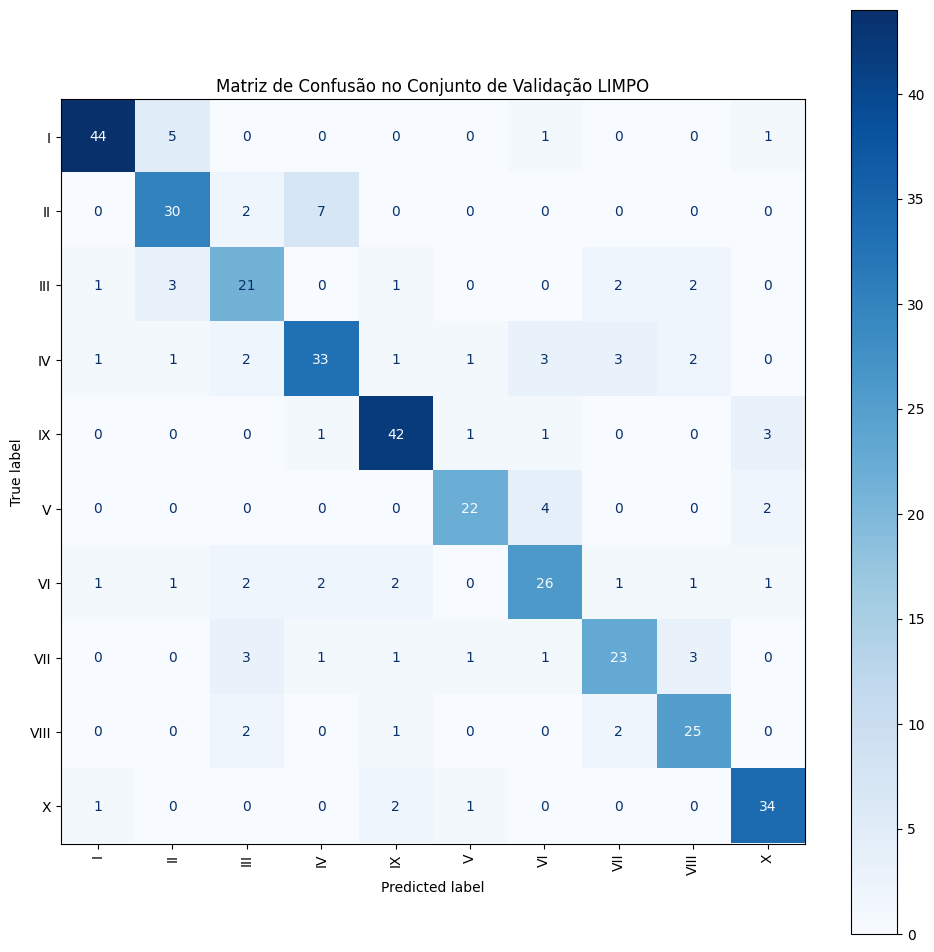

In [79]:
print("Identificando problemas no conjunto de validação usando o objeto 'lab_valid'...")

# Garante que o objeto lab_valid, criado na análise de validação, exista.
if 'lab_valid' not in globals():
    raise NameError("Objeto 'lab_valid' não encontrado. Por favor, execute a célula de análise do conjunto de validação primeiro.")

# Pega o relatório completo de issues do objeto lab_valid
validation_issues_df = lab_valid.get_issues()

# Filtra para obter os índices de qualquer linha que seja um outlier OU um erro de rótulo
validation_indices_to_remove = validation_issues_df.query(
    "is_outlier_issue == True or is_label_issue == True"
).index

print(f"Encontrados {len(validation_indices_to_remove)} problemas no conjunto de validação para remover.")


# --- PASSO 2: Criar os Conjuntos de Validação Limpos ---
print("\nIniciando a limpeza do conjunto de validação...")
print(f"Tamanho antes: {len(df_valid)} amostras.")

# Cria as versões finais e limpas do conjunto de validação
df_valid_cleaned = df_valid.drop(validation_indices_to_remove).reset_index(drop=True)
X_valid_cleaned = np.delete(X_valid, validation_indices_to_remove, axis=0)
y_valid_cleaned = np.delete(y_valid, validation_indices_to_remove, axis=0)

print(f"Tamanho após: {len(df_valid_cleaned)} amostras.")
print("Conjuntos de validação limpos ('_cleaned') foram criados com sucesso!")


# --- PASSO 3: Avaliar o Modelo nos Dados Limpos ---
print("\nUsando o modelo treinado para fazer predições no conjunto de validação LIMPO...")
y_pred_on_clean_valid = model_xgb.predict(X_valid_cleaned)
print("Predições concluídas.")

print("\n--- Avaliação da Performance no Conjunto de Validação LIMPO ---")

# Acurácia Geral
accuracy_clean = accuracy_score(y_valid_cleaned, y_pred_on_clean_valid)
print(f"Acurácia no Conjunto de Validação LIMPO: {accuracy_clean:.4f} ({accuracy_clean:.2%})")

# Coeficiente de Correlação de Matthews (MCC)
mcc_clean = matthews_corrcoef(y_valid_cleaned, y_pred_on_clean_valid)
print(f"MCC no Conjunto de Validação LIMPO: {mcc_clean:.4f}")

# Relatório de Classificação Detalhado
class_names = [id_to_label[i] for i in sorted(id_to_label.keys())]
print("\nRelatório de Classificação (Validação LIMPA):")
print(classification_report(y_valid_cleaned, y_pred_on_clean_valid, target_names=class_names))

# Matriz de Confusão Visual
print("\nMatriz de Confusão (Validação LIMPA):")
fig, ax = plt.subplots(figsize=(12, 12))
ConfusionMatrixDisplay.from_predictions(
    y_true=y_valid_cleaned,
    y_pred=y_pred_on_clean_valid,
    ax=ax,
    display_labels=class_names,
    xticks_rotation="vertical",
    cmap=plt.cm.Blues
)
plt.title("Matriz de Confusão no Conjunto de Validação LIMPO")
plt.show()